In [2]:
%cd ~/desktop/RNA/casp16

/Users/sumishunsuke/Desktop/RNA/casp16


# energy calc 

In [5]:
pdb_dir="./datasets/casp16/R1241/pdb"

!ls {pdb_dir}/*pdb | wc -l

!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir}

     133
['S_000278.pdb', 'S_000287.pdb', 'S_000293.pdb', 'S_000046.pdb']
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 82, in <module>
    main()
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 65, in main
    res_rnabriq = RNA_BRiQ.RNA_BRiQ_eval_batch(args.pdb_dir, args.out_dir)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./src/score/RNA_BRiQ.py", line 65, in RNA_BRiQ_eval_batch
    with open(os.path.join(out_file, f), "r") as f:
                                     ^
UnboundLocalError: cannot access local variable 'f' where it is not associated with a value


In [9]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
all_pdb_ids[:3]

['S_000001', 'S_000002', 'S_000003']

In [10]:
# re-proc

all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
print(len(all_pdb_ids))

energies = {}
unprocessed = []
for pdb_id in all_pdb_ids:
    f = f"{pdb_dir}/{pdb_id}.briq.out"
    try:
        with open(f) as fh: lines = fh.readlines()
        energies[f] = float(lines[-1].strip().replace("Energy: ", ""))
    except:
        unprocessed.append(pdb_id)

print(len(energies), len(unprocessed))

133
128 5


In [11]:
# import sys
# sys.path.append("./")
# from src.score import RNA_BRiQ
# from multiprocessing import Pool

# with Pool(5) as pool:
#     results = pool.map(
#         RNA_BRiQ.process_pdb_file_eval,
#         [f"{pdb_dir}/{pdb_id}.pdb" for pdb_id in unprocessed]
#         )

# energy書き出し

In [12]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace(".briq.out", "")
    pdb_energy[basename] = energies


pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
df_briq.head(3)

,pdb,BRiQscore
0,S_000001,-1090.52
1,S_000002,-1033.84
2,S_000003,-1106.49


In [14]:
df_farfar = pd.read_csv(f"{pdb_dir}/R1241_FARFAR2_scores.csv")
df_farfar = df_farfar[["score", "description"]]
df_farfar.columns = ["FARFARscore", "pdb"]
df_farfar.head(3)

df = pd.merge(df_briq, df_farfar, on="pdb")
# df.to_csv(f"{pdb_dir}/R1241_scores.csv", index=False)

# 可視化

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(133, 3)


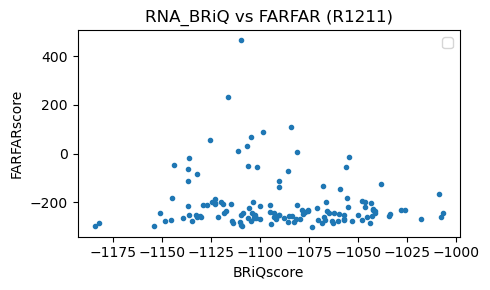

In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/R1241_scores.csv")



n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_farfar_top = df_scores.sort_values("FARFARscore", ascending=True).head(n_take)
df_both_top = pd.concat([df_briq_top, df_farfar_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["FARFARscore"], marker=".")
# plt.scatter(df_both_top["BRiQscore"], df_both_top["FARFARscore"], marker=".", color="orange", label=f"Top {n_take}")
plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("FARFARscore")
plt.title("RNA_BRiQ vs FARFAR (R1211)")

print(df_both_top.shape)
plt.tight_layout()
plt.savefig(f"{pdb_dir}/R1241_scores.pdf")

# 距離行列計算

In [19]:
%cd ~/desktop/RNA/casp16
pdb_dir="./datasets/casp16/R1241/pdb"

from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/sumishunsuke/Desktop/RNA/casp16


In [20]:
!time python scripts/calc_rmsd.py --pdb_dir {pdb_dir} --cpu 6

['S_000001.pdb', 'S_000002.pdb', 'S_000003.pdb', 'S_000004.pdb', 'S_000005.pdb']
Number of pdb files: 133
Calculating RMSD matrix 133x133 using 6 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 30th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 80th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 130th pdb file
RMSD matrix saved

real	6m44.866s
user	37m54.208s
sys	0m32.324s


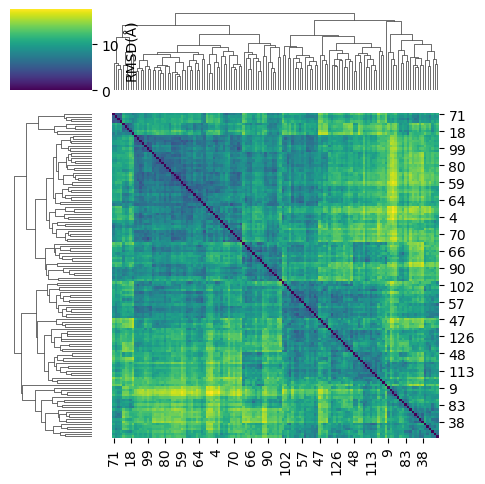

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
plt.tight_layout()
# plt.savefig(f"{pdb_dir}/rmsd_clustermap.png", dpi = 300)

In [37]:
df_rmsd = pd.DataFrame(rmsd, columns=all_pdb_ids, index=all_pdb_ids)
# df_rmsd.to_csv(f"{pdb_dir}/rmsd_matrix_sorted_id.csv")

# clustering 

In [23]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

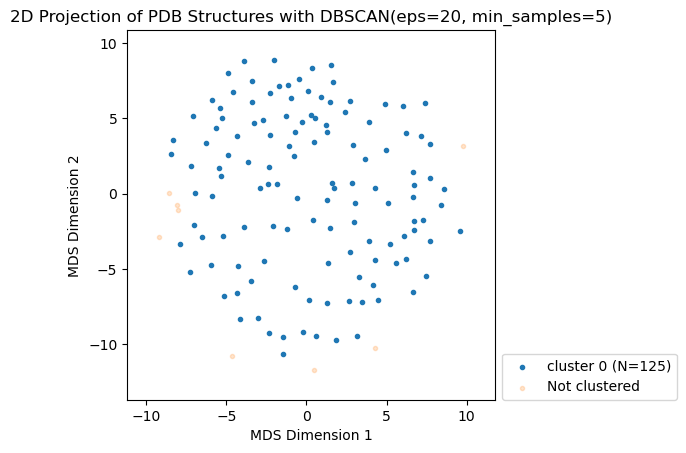

In [46]:
from sklearn.cluster import DBSCAN
eps =  20
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
# plt.savefig(f"{pdb_dir}/rmsd_mds_dbscan.png", dpi = 300)
plt.show()


In [47]:
df_scores["cluster"] = clustering.labels_
# df_scores.to_csv(f"{pdb_dir}/R1211_scores_clustered.csv", index=False)
# df_scores = pd.read_csv(f"{pdb_dir}/R1241_scores_clustered.csv")
df_scores.head(3)

,pdb,BRiQscore,FARFARscore,cluster
0,S_000001,-1090.52,-254.274,0
1,S_000002,-1033.84,-249.883,0
2,S_000003,-1106.49,32.698,0


In [50]:
pdb_list = []

for c in [0]:
    n = sum(df_scores["cluster"] == c)
    print(f"Cluster {c} (N={n})")
    print(df_scores[df_scores["cluster"] == c].sort_values("BRiQscore").head(5))
    pdb_list.extend(df_scores[df_scores["cluster"] == c].sort_values("BRiQscore").head(5)["pdb"].values)
    print(df_scores[df_scores["cluster"] == c].sort_values("FARFARscore").head(5))
    pdb_list.extend(df_scores[df_scores["cluster"] == c].sort_values("FARFARscore").head(5)["pdb"].values)
    print("**"*20)


pdb_list = list(set(pdb_list))

Cluster 0 (N=125)
          pdb  BRiQscore  FARFARscore  cluster
131  S_000297   -1184.19     -297.373        0
87   S_000113   -1181.93     -287.050        0
84   S_000107   -1154.28     -296.829        0
70   S_000079   -1151.22     -244.604        0
76   S_000096   -1148.26     -278.003        0
          pdb  BRiQscore  FARFARscore  cluster
107  S_000254   -1073.54     -303.358        0
99   S_000190   -1109.16     -299.486        0
131  S_000297   -1184.19     -297.373        0
84   S_000107   -1154.28     -296.829        0
59   S_000065   -1109.84     -294.883        0
****************************************


In [52]:

df_rmsd[pdb_list].loc[pdb_list].to_csv(f"{pdb_dir}/rmsd_matrix_clustered_top5.csv")